In [17]:
#pip install pandas matplotlib vaderSentiment
#Download the required libraries


In [20]:
#import all reuired libraries
import pandas as pd
import uuid
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt

In [21]:

#load the files

google = pd.read_excel(r"C:\Users\Ujwal Kavalipati\Downloads\google_reviews.xlsx")


reviewsio = pd.read_excel(r"C:\Users\Ujwal Kavalipati\Downloads\reviewsio_reviews.xlsx")
reviewsio["source"] = "Reviews.io"


In [24]:
#Data cleaning steps
#after exploring the data, I have decided to just use columns which are useful: mainly reviews and timeframe
#lets assign a unique review id for both sources


google=google.rename(columns={'rsqaWe': 'timeframe', 'wiI7pd': 'review'})
google["source"] = "Google"
google["review_id"] = [str(uuid.uuid4()) for _ in range(len(google))]
google_short= google[['review_id','timeframe','review','source']]
print(google_short.head())


reviewsio=reviewsio.rename(columns={'Review__dateSource': 'timeframe', 'Review__body': 'review'})
reviewsio["source"] = "Reviews.io"
reviewsio["review_id"] = [str(uuid.uuid4()) for _ in range(len(reviewsio))]
reviewsio_short=reviewsio[['review_id','timeframe','review','source']]

print(reviewsio_short.head())

                              review_id     timeframe  \
0  7ead8bca-8f2a-4a9c-a922-fc2b9d87f973  3 months ago   
1  838290cc-1890-4cd7-bb70-8bc082fb660d   2 weeks ago   
2  f4375cb7-bb02-4c39-a619-3c7772e05af1  4 months ago   
3  9c3c4d9c-fe03-448d-ad12-e50fe5d10f80  4 months ago   
4  d633af1a-b9c0-4fa0-a9cc-603d704ad5f1  2 months ago   

                                              review  source  
0  It's a good program but is not up to date.  So...  Google  
1  I am ropable my details were just given out li...  Google  
2  You vile disgusting company!!! You do not have...  Google  
3  Some contacts are easy to find, but not all. s...  Google  
4  Data quality is not good. Most of the phone nu...  Google  
                              review_id          timeframe  \
0  a4660f0b-cdf1-4633-888c-507799e19023  Posted 1 year ago   
1  8f32e338-8578-4e4e-9ab2-d64b96841fcf  Posted 1 year ago   
2  3dd70c28-620b-401d-964b-ad8fc4a2842a  Posted 1 year ago   
3  1c00fc58-ea20-4aa5-aa45-f749

In [25]:
#combine the data from 2 sources now and remove all null rows
df = pd.concat([google_short, reviewsio_short], ignore_index=True)

df = df[["review_id", "review", "source"]].dropna()
df["review"] = df["review"].astype(str)

#remove any duplicate reviews
df = df.drop_duplicates(subset=["review"]).reset_index(drop=True)


#check that we dont have any null values in our reviews dataframe
df.isna().sum()

review_id    0
review       0
source       0
dtype: int64

In [26]:
"""I used VADER because it’s a rule-based sentiment engine that understands intensifiers,
negations, and emotional phrasing. For example, phrases like ‘very angry’ and ‘no respect for my privacy’ 
are weighted more heavily, which correctly captures the intensity of customer frustration.

VADER stands for Valence Aware Dictionary and sEntiment Reasoner- it is a quick sentiment analyser 
based on human emotions and text

it produces  an interpretable sentiment score between −1 and +1.  -1 means strongly negative
"""
analyzer = SentimentIntensityAnalyzer()

df["sentiment_score"] = df["review"].apply(
    lambda x: analyzer.polarity_scores(x)["compound"]
)

def label(score):
    if score >= 0.05:
        return "Positive"
    elif score <= -0.05:
        return "Negative"
    else:
        return "Neutral"

df["sentiment"] = df["sentiment_score"].apply(label)
df.sample(5)

,review_id,review,source,sentiment_score,sentiment
22,feb3939c-237b-4156-aebc-4cf5b8d85d1e,"Peggy was GREAT. I found her Informative, help...",Google,0.9340,Positive
119,688aab88-2492-4e13-ba67-f253a83b8a5e,"Great product, very helpful in my work environ...",Reviews.io,0.8016,Positive
179,eff8a853-90d1-4118-afb7-7e4b2d68b50d,Great service to get more phone numbers.,Reviews.io,0.6249,Positive
21,d3bc8bac-f171-4ab6-8b86-9ec442ca37d3,"Peggy is amazing. Very friendly, helpful and e...",Google,0.9527,Positive
20,2e4dccc2-e7ea-4e02-89e4-4d063dae882f,Amazing app for new agents but the information...,Google,0.8422,Positive


In [62]:
#getting the sumary by each source
summary = (
    df.groupby(["source", "sentiment"])
      .size()
      .reset_index(name="count")
)



summary["percent"] = (
    summary.groupby("source")["count"]
           .apply(lambda x: (x / x.sum() * 100).round(1))
)

summary["percent"] = summary["percent"].astype(str) + "%"


print(summary)

       source sentiment  count percent
0      Google  Negative      7   12.3%
1      Google   Neutral      5    8.8%
2      Google  Positive     45   78.9%
3  Reviews.io  Negative      8    5.4%
4  Reviews.io   Neutral     15   10.2%
5  Reviews.io  Positive    124   84.4%


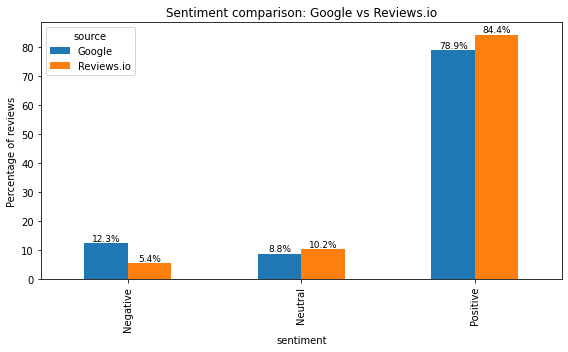

In [28]:
#plot by source and sentiment 
pivot = summary.pivot(index="sentiment", columns="source", values="percent")
ax = pivot.plot(kind="bar", figsize=(8, 5))

ax.set(
    ylabel="Percentage of reviews",
    title="Sentiment comparison: Google vs Reviews.io"
)

for p in ax.patches:
    ax.text(
        p.get_x() + p.get_width() / 2,
        p.get_height(),
        f"{p.get_height():.1f}%",
        ha="center",
        va="bottom",
        fontsize=9
    )

plt.tight_layout()

In [61]:
#based on few reviews I read from google and reviews io- I am putting some pain keywords to find if any of them is repeated

pain_keywords = {
    "Data Quality": ["data", "incorrect", "wrong", "outdated", "accuracy"],
    "Privacy & Consent": ["privacy", "consent", "intrusive", "details", "shared"],
    "Contact Issues": ["phone", "email", "contact", "called", "spam"],
    "System / Platform": ["system", "platform", "program", "process"],
    "Updates & Timeliness": ["update", "delay", "slow", "waiting", "time"],
    "Trust": ["trust", "scam", "fraud", "legit"],
}


def detect_pain(text):
    text = text.lower()
    hits = []
    for pain, words in pain_keywords.items():
        if any(w in text for w in words):
            hits.append(pain)
    return hits

df["pain_points"] = df["review"].apply(detect_pain)





In [51]:
# we will only consider pain points when sentiment is negative as this will avoid false positives
df["pain_points"] = df.apply(
    lambda r: detect_pain(r["review"]) if r["sentiment"] == "Negative" else [],
    axis=1
)
(df.head())

,review_id,review,source,sentiment_score,sentiment,pain_points
0,7ead8bca-8f2a-4a9c-a922-fc2b9d87f973,It's a good program but is not up to date. So...,Google,0.2382,Positive,[]
1,838290cc-1890-4cd7-bb70-8bc082fb660d,I am ropable my details were just given out li...,Google,-0.3065,Negative,[Privacy & Consent]
2,f4375cb7-bb02-4c39-a619-3c7772e05af1,You vile disgusting company!!! You do not have...,Google,-0.8624,Negative,[Contact Issues]
3,9c3c4d9c-fe03-448d-ad12-e50fe5d10f80,"Some contacts are easy to find, but not all. s...",Google,0.5764,Positive,[]
4,d633af1a-b9c0-4fa0-a9cc-603d704ad5f1,Data quality is not good. Most of the phone nu...,Google,-0.3412,Negative,"[Data Quality, Contact Issues]"


In [60]:
#let's print the top pain points for the customers
pain_exploded = df.explode("pain_points")

pain_summary = (
    pain_exploded[pain_exploded["pain_points"].notna()]
    .groupby(["source", "pain_points"])
    .size()
    .reset_index(name="mentions")
    .sort_values("mentions", ascending=False)
)

print(pain_summary.head(10))





       source           pain_points  mentions
2      Google     Privacy & Consent         3
6  Reviews.io  Updates & Timeliness         3
0      Google        Contact Issues         2
1      Google          Data Quality         2
4  Reviews.io        Contact Issues         2
5  Reviews.io          Data Quality         2
3      Google  Updates & Timeliness         1
